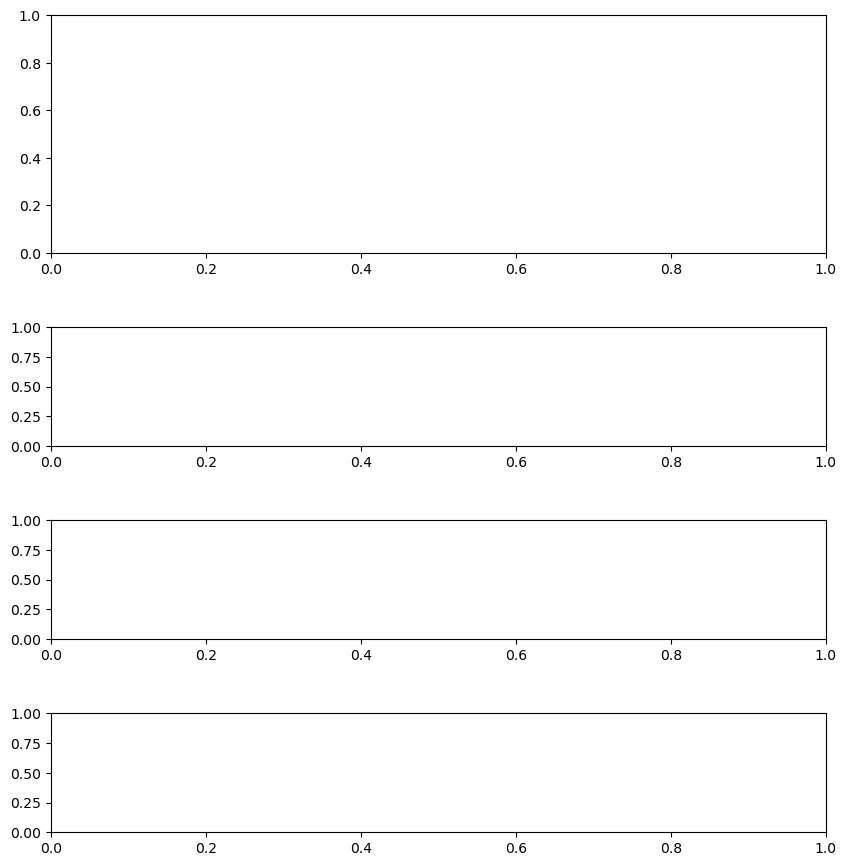

In [5]:
import tkinter as tk
from tkinter import ttk
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from statsmodels.tsa.arima.model import ARIMA
from pandas.tseries.offsets import BDay

def clear_plots(axes):
    for ax in axes:
        ax.clear()

def setup_gui():
    window = tk.Tk()
    window.title("Stock Analysis with Volume, MACD, RSI, and ARIMA Predictions")

    ttk.Label(window, text="Ticker:").pack(side=tk.LEFT)
    ticker_entry = ttk.Entry(window)
    ticker_entry.pack(side=tk.LEFT)

    ttk.Label(window, text="Period:").pack(side=tk.LEFT)
    period_var = tk.StringVar(value="1y")
    ttk.OptionMenu(window, period_var, "1d", "5d", "1mo", "3mo", "6mo", "1y", "2y", "5y", "10y", "ytd", "max").pack(side=tk.LEFT)

    analyze_button = ttk.Button(window, text="Analyze", command=lambda: fetch_and_analyze_data(ticker_entry.get(), period_var.get(), ax1, ax2, ax3, ax4, canvas))
    analyze_button.pack(side=tk.LEFT)
    
#    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 12), gridspec_kw={'height_ratios': [2, 1]})
#    fig.subplots_adjust(hspace=0.3)  # Adjust space between the rows
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(10, 16), gridspec_kw={'height_ratios': [2, 1, 1, 1]})
    fig.subplots_adjust(hspace=0.5)  # Increase the vertical space between plots


    canvas = FigureCanvasTkAgg(fig, master=window)
    canvas.draw()
    canvas.get_tk_widget().pack(side=tk.BOTTOM, fill=tk.BOTH, expand=True)

    window.mainloop()

def fetch_stock_data(ticker, period):
    stock = yf.Ticker(ticker)
    data = stock.history(period=period)
    data.reset_index(inplace=True)
    return data

def analyze_data(data):
    breakout_indices = []
    consolidation_indices = []

    for i in range(20, len(data)):
        if i >= 40:
            price_increase = (data['Close'].iloc[i] - data['Close'].iloc[i - 40]) / data['Close'].iloc[i - 40]
            volume_increase = data['Volume'].iloc[i] > data['Volume'].rolling(window=40).mean().iloc[i]
            if price_increase > 0.7 and volume_increase:
                breakout_indices.append(i)
        if breakout_indices:
            last_breakout_index = breakout_indices[-1]
            if i > last_breakout_index + 5:
                price_range = data['Close'].iloc[last_breakout_index:i+1]
                if price_range.max() <= data['Close'].iloc[last_breakout_index] * 1.25 and price_range.min() >= data['Close'].iloc[last_breakout_index] * 0.75:
                    volume_is_low = data['Volume'].iloc[i] < data['Volume'].rolling(window=40).mean().iloc[i]
                    if volume_is_low:
                        consolidation_indices.append(i)
            
    return breakout_indices, consolidation_indices

def calculate_obv(close_prices, volumes):
    obv = [0]
    for i in range(1, len(close_prices)):
        if close_prices[i] > close_prices[i-1]:
            obv.append(obv[-1] + volumes[i])
        elif close_prices[i] < close_prices[i-1]:
            obv.append(obv[-1] - volumes[i])
        else:
            obv.append(obv[-1])
    return obv

def calculate_macd(data, slow=26, fast=12, smooth=9):
    exp1 = data['Close'].ewm(span=fast, adjust=False).mean()
    exp2 = data['Close'].ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=smooth, adjust=False).mean()
    return macd, signal

def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = ((delta > 0) * delta).fillna(0)
    loss = ((delta < 0) * -delta).fillna(0)

    average_gain = gain.rolling(window).mean()
    average_loss = loss.rolling(window).mean()

    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


def plot_rsi(data, ax):
    # Ensure that the data has been processed correctly and 'Date' is the index
    rsi = calculate_rsi(data)
    ax.clear()  # Clear previous plots
    ax.plot(data.index, rsi, label='RSI', color='purple')
    ax.axhline(70, color='red', linestyle='--', linewidth=0.5, label='Overbought (70)')
    ax.axhline(30, color='green', linestyle='--', linewidth=0.5, label='Oversold (30)')
    ax.set_ylim([0, 100])
    ax.legend()
    ax.set_title('Relative Strength Index (RSI)')

def plot_macd(data, ax):
    # Ensure that the data has been processed correctly and 'Date' is the index
    macd, signal = calculate_macd(data)
    ax.clear()  # Clear previous plots
    ax.plot(data.index, macd, label='MACD', color='blue')
    ax.plot(data.index, signal, label='Signal Line', color='red')
    ax.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Zero line for MACD
    ax.legend()
    ax.set_title('Moving Average Convergence Divergence (MACD)')

def plot_data(data, breakout_indices, consolidation_indices, ax1, ax2, ax3, ax4):
    ax1.plot(data['Date'], data['Close'], label='Samanssons breakout och consolidation', color='blue')
    ax1.scatter(data['Date'].iloc[breakout_indices], data['Close'].iloc[breakout_indices], color='red', label='Breakout', marker='^', zorder=5)
    ax1.scatter(data['Date'].iloc[consolidation_indices], data['Close'].iloc[consolidation_indices], color='green', label='Consolidation', marker='v', zorder=5)
    ax1.legend()
    ax1.set_title('Close Price')

    obv_values = calculate_obv(data['Close'], data['Volume'])
    ax2.plot(data['Date'], obv_values, label='On-Balance Volume', color='purple')
    ax2.legend()
    ax2.set_title('On-Balance Volume')

    plot_rsi(data, ax3)
    plot_macd(data, ax4)

def fetch_and_analyze_data(ticker, period, ax1, ax2, ax3, ax4, canvas):
    data = fetch_stock_data(ticker, period)
    breakout_indices, consolidation_indices = analyze_data(data)

    clear_plots([ax1, ax2, ax3, ax4])

    plot_data(data, breakout_indices, consolidation_indices, ax1, ax2, ax3, ax4)

    canvas.draw()

def run_arima_and_rsi(ticker, period, ax1, ax2, ax3, canvas):
    data = fetch_stock_data(ticker, period)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data.asfreq('B')

    model = ARIMA(data['Close'].dropna(), order=(1, 1, 1))
    results = model.fit()

    steps = 30
    forecast = results.get_forecast(steps=steps)
    mean_forecast = forecast.predicted_mean
    conf_int = forecast.conf_int()

    ax1.plot(data.index, data['Close'], label='Actual Data', color='blue')
    last_date = data.index.max()
    forecast_dates = [last_date + BDay(i) for i in range(1, steps + 1)]
    ax1.plot(forecast_dates, mean_forecast, label='Predicted', color='red', linestyle='--')
    ax1.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    ax1.legend()
    ax1.set_title('Close Price with ARIMA Predictions')

    plot_rsi(data, ax3)

    canvas.draw()

if __name__ == "__main__":
    setup_gui()
